In [1]:
%matplotlib notebook

import numpy as np
import astropy.units as u
import astropy.constants as const

import matplotlib.pyplot as plt


from plasmapy.particles import Particle
from plasmapy import formulary
from plasmapy.simulation.particle_integrators import boris_push

# ExB Drift 

The ExB drift occurs when a charged particle moves through perpendicular E and B fields. In this example, we will calculate the ExB velocity for the particle defined below

In [2]:
# Define strengths for the E and B fields
E0 = 0.1 * u.V / u.m
B0 = 5*u.T
particle = Particle('p+')
Vperp = 1*u.m/u.s

Calculate the theoretical ExB drift velocity using the PlasmaPy formulary function

In [3]:
v_ExB = formulary.drifts.ExB_drift(E0*np.array([0,1,0]), B0*np.array([0,0,1]))
print(f"ExB Velocity: {v_ExB}")

ExB Velocity: [0.02 0.   0.  ] m / s


In order to validate this calculation, we want to run a particle tracing simulation to visualize the particle trajectory in the fields. To do so, we'll need to start by defining the particles initial velocity and position. To keep things general, let's define them in terms of the fundamental length and time scales of the problem, which are the cyclotron period and the gyroradius (or Larmor radius)

In [4]:
fci = formulary.frequencies.gyrofrequency(np.max(B0), particle)/2/np.pi/u.rad
print(f"Cyclotron period: {(1/fci).to(u.ns).value:.1f} ns")
rLarmor = formulary.lengths.gyroradius(B0, particle, Vperp=Vperp) 
print(f"rLarmor: {rLarmor.to(u.nm).value:.1f} nm")

Cyclotron period: 13.1 ns
rLarmor: 2.1 nm


Now we can define the particles initial velocity and positon. We'll chose the intial position so the gyrocenter is at (x,y)=(0,0). We'll give the particle some perpendicular velocity and a paralell velocity, so it orbits while drifting along the field.

In [5]:
v0 = np.array([Vperp.to(u.m/u.s).value,0,1])*u.m/u.s
x0 = np.array([0, rLarmor.to(u.m).value, 0])*u.m

Now we'll define the time and space axes for our problem. We want to track the particle for several cyclotron periods (1/fci) and the time step must be much smaller than the cyclotron period.

In [6]:
times = np.arange(0, (20/fci).to(u.s).value, (1/fci/100).to(u.s).value)*u.s

We can likewise define the space axes in terms of the other constants in the problem. We'll make the domain a bit larger than the gyroradius in the XY plane (so the particle will never leave the domain). In the z direction, we want to make the domain larger than the distance the particle will travel with its initial velocity.

In [7]:
# Define the spatial grid
xaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100).to(u.m).value
yaxis = np.linspace(-1.5*rLarmor, 1.5*rLarmor, num=100).to(u.m).value
zaxis = np.linspace(0, 1.2*v0[2]*times[-1], num=100).to(u.m).value
# Create grids of coordinates - we'll use these later
X, Y, Z = np.meshgrid(xaxis, yaxis, zaxis, indexing='ij')

Finally, we need to create grids of fields at each of these positions. For this problem this is technically unnecessary, since the fields are the same everywhere. However, in later examples we may want to let them change, so let's define them here anyway

In [8]:
# Create grids of fields to go on the spatial grid
E = np.zeros((*X.shape, 3))
E[..., 1] = E0.to(u.V/u.m).value

B = np.zeros((*X.shape, 3))
B[..., 2] = B0.to(u.T).value

Now we just need a function that takes our particle and tracks it through the fields over the times we specified. The following function does just that. For more details, please see the line comments

In [9]:
def track_particle(xaxis, yaxis, zaxis, E, B, x0, v, particle, times):
    """
    This function tracks a single particle with intial position x0 and velocity v0 through the times in the
    provided array of times. 
    """

    dt = np.mean(np.gradient(times)).to(u.s).value # Simulation timestep

    # Initialze an array to save the trajectories into 
    x = np.zeros((times.size+1, 3))
    # Set the first entry to the initial position of the particle
    x[0,:] = x0.to(u.m).value
    
    # Strip the astropy units off of some quantities we will use on each iteration (for speed)
    v = v.to(u.m/u.s).value
    q = particle.charge.to(u.C).value
    m = particle.mass.to(u.kg).value
    
    # Loop over all of the times in the times array
    for i, t in enumerate(times):
        # Locate the nearest grid cell to the particle
        xi = np.argmin(np.abs(x[i,0] - xaxis))
        yi = np.argmin(np.abs(x[i,1] - yaxis))
        zi = np.argmin(np.abs(x[i,2] - zaxis))
        
        # Get the E and B fields at the current particle location
        _E = np.array([E[xi, yi, zi, :],])
        _B = np.array([B[xi, yi, zi, :],])

        # The Boris push function advances the particles in a way that conserves kinetic energy
        # This function is part of PlasmaPy
        _x = x[i,:]
        boris_push(_x, v, _B, _E, q, m, dt)
        x[i+1,:]=_x
        
    return x*u.m

# Call the function on our particle + fields
x = track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times)

Done! Now we can visualize the results. First, let's plot the evolution of the coordinates of the particle in time. We see that 

- The ExB drift moves the particle in the X direction.
- The particle gyrates around it's gyrocenter in the XY plane.
- The particle moves with constant velocity in the Z direction. 

Notice how the gyrocenter of the particle in the X direction follows the line predicted by the ExB velocity we calcualted using  the PlasmaPy formulary function. 

<IPython.core.display.Javascript object>


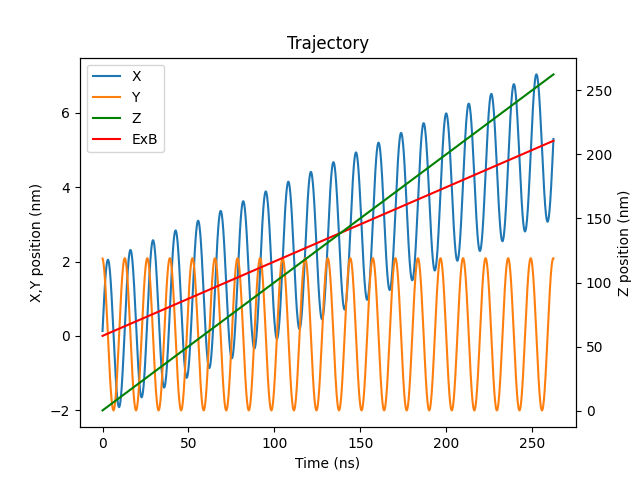

In [10]:
fig, ax = plt.subplots()
ax.set_title("Trajectory")
ax.set_xlabel("Time (ns)")

ax.plot(times.to(u.ns).value, x[:-1, 0].to(u.nm).value, label='X')
ax.plot(times.to(u.ns).value, x[:-1, 1].to(u.nm).value, label='Y')
ax.plot([], [], color='green', label='Z')
ax.plot(times.to(u.ns).value, (v_ExB[0]*times).to(u.nm).value, color='red', label='ExB')
ax.set_ylabel("X,Y position (nm)")

ax2 = ax.twinx()
ax2.plot(times.to(u.ns).value, x[:-1, 2].to(u.nm).value, label='Z', color='green')
ax2.set_ylabel("Z position (nm)");
ax.legend();

We can also look at the particle motion in 3D. Here you can again see the particle gyrating around its guiding center, which moves with the theoretical velocity of the ExB drift.

<IPython.core.display.Javascript object>


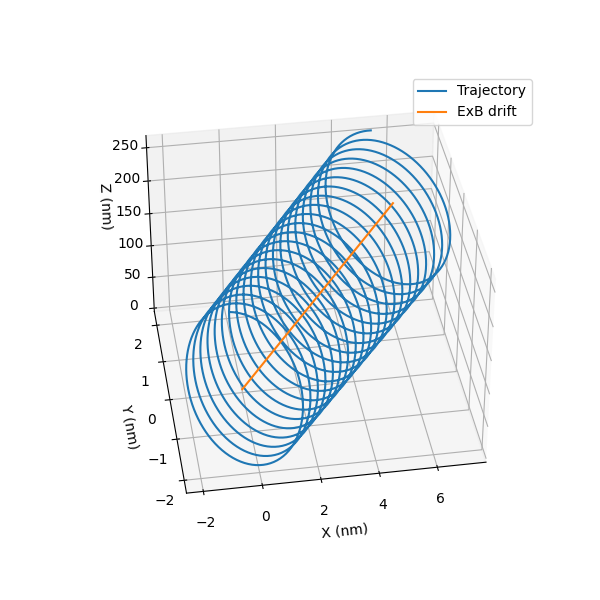

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

# Plot the orbit
ax.plot(x[:,0].to(u.nm).value, x[:,1].to(u.nm).value, x[:,2].to(u.nm).value, label="Trajectory")

# Plot the theoretical drift
x_final = (times[-1]*(v_ExB + np.array([0,0,v0[2].value])*v0.unit)).to(u.nm).value

ax.plot([0,x_final[0]], [0,x_final[1]], [0,x_final[2]], label='ExB drift')

#ax.plot(np.zeros(10), np.zeros(10), np.arange(10))
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")

ax.legend();

# $\nabla$ B Drift

In [12]:
particle = Particle('p+')

gradB = -0.5*u.T/u.nm
B0 = 6*u.T

B = np.zeros((*X.shape, 3))
B[..., 2] = (B0 - gradB*X*u.m).to(u.T).value

E = np.zeros((*X.shape, 3))

The magnetic field is constant in Y and Z, but has a gradient in X, while the electric field is zero everywhere.

<IPython.core.display.Javascript object>


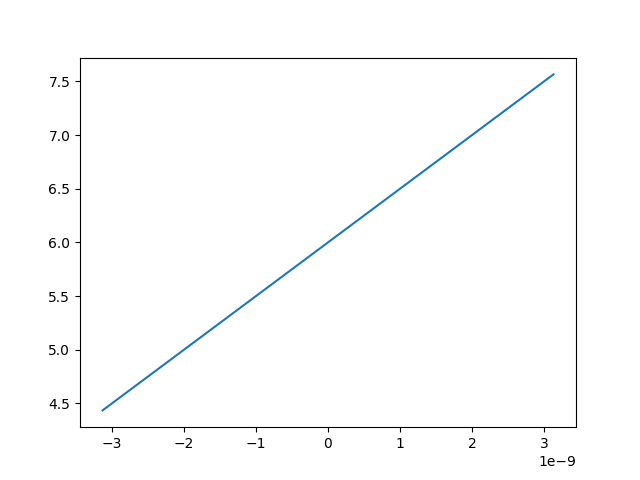

In [13]:
fig, ax = plt.subplots()
ax.plot(xaxis, B[:,50,50,2]);

Now we need to set up the time axis again. This time, since B is changing, we'll use the minimum gyroperiod

In [14]:
min_fci = formulary.frequencies.gyrofrequency(np.min(B[...,2])*u.T, particle)/2/np.pi/u.rad

times = np.arange(0, (20/min_fci).to(u.s).value, (1/min_fci/100).to(u.s).value)*u.s

In [15]:
v0 = np.array([.5,0,0])*u.m/u.s
x0 = np.array([0, 0, 0])*u.m

In [16]:
# Call the function on our particle + fields
x = track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times)

In the 2D and 3D plots we see the expected behavior: the particle gyrates in the XY plane, but the gradB drift results in a guiding center motion in the +Y direction

<IPython.core.display.Javascript object>


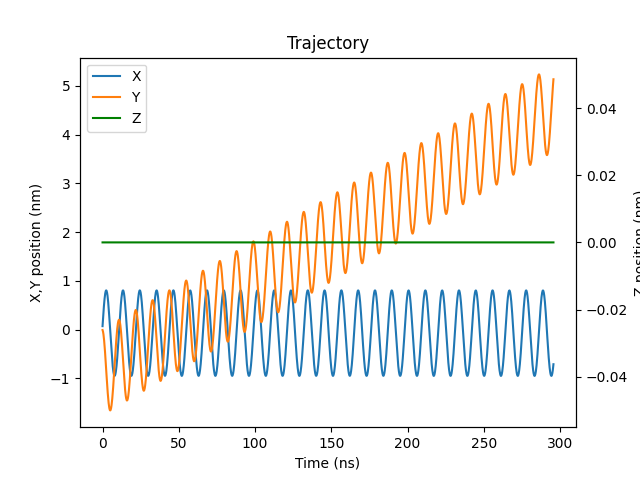

In [17]:
fig, ax = plt.subplots()
ax.set_title("Trajectory")
ax.set_xlabel("Time (ns)")

ax.plot(times.to(u.ns).value, x[:-1, 0].to(u.nm).value, label='X')
ax.plot(times.to(u.ns).value, x[:-1, 1].to(u.nm).value, label='Y')
ax.plot([], [], color='green', label='Z')
ax.set_ylabel("X,Y position (nm)")

ax2 = ax.twinx()
ax2.plot(times.to(u.ns).value, x[:-1, 2].to(u.nm).value, label='Z', color='green')
ax2.set_ylabel("Z position (nm)");
ax.legend();

<IPython.core.display.Javascript object>


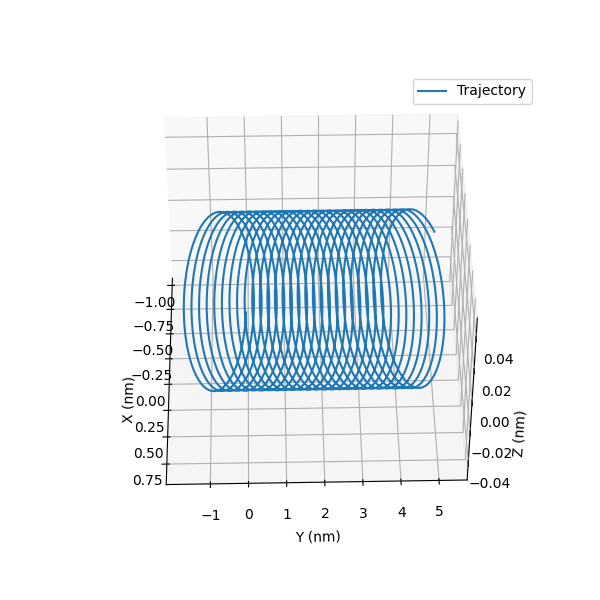

In [18]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

# Plot the orbit
ax.plot(x[:,0].to(u.nm).value, x[:,1].to(u.nm).value, x[:,2].to(u.nm).value, label="Trajectory")

# Plot the theoretical drift
x_final = (times[-1]*(v_ExB + np.array([0,0,v0[2].value])*v0.unit)).to(u.nm).value
#ax.plot(np.zeros(10), np.zeros(10), np.arange(10))
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")

ax.legend();

# Curvature Drift

The curvature drift occurs when particles travel through a region of curved magnetic field

In [19]:
particle = Particle('p+')

R_curvature =100*u.nm
B0 = 5*u.T

B = np.zeros((*X.shape, 3))
theta = np.arctan2(Y -R_curvature.to(u.m).value/10, X)
B[...,0] = -np.sin(theta)*B0.to(u.T).value
B[...,1] = np.cos(theta)*B0.to(u.T).value

E = np.zeros((*X.shape, 3))

This is a bit of a tricky field, so let's make a vector plot to visualize it

<IPython.core.display.Javascript object>


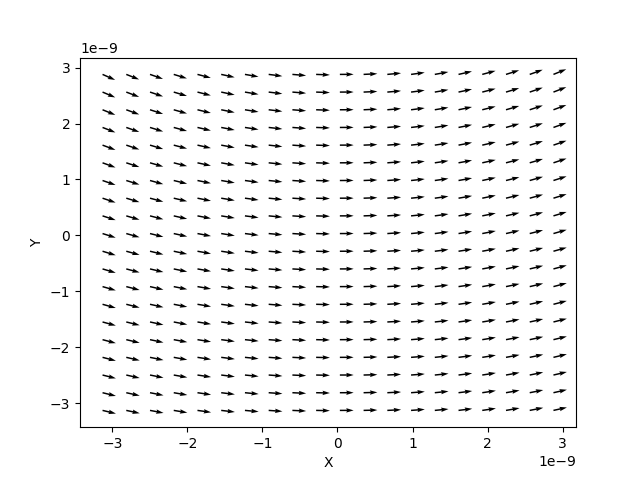

In [20]:
fig, ax = plt.subplots()
step=5
ax.quiver(X[::step,::step, 50], Y[::step, ::step, 50], 
          B[::step,::step, 50, 0], B[::step, ::step, 50, 1]);
ax.set_xlabel("X")
ax.set_ylabel("Y");

In [21]:
min_fci = formulary.frequencies.gyrofrequency(np.min(np.linalg.norm(B, axis=-1))*u.T, particle)/2/np.pi/u.rad

times = np.arange(0, (20/min_fci).to(u.s).value, (1/min_fci/100).to(u.s).value)*u.s

Create particles that start on the left side of the domain in X and move to the right 

In [22]:
v0 = np.array([.01,0,0])*u.m/u.s
x0 = np.array([-2e-9, 0, 0])*u.m

In [23]:
# Call the function on our particle + fields
x = track_particle(xaxis, yaxis, zaxis, E, B, x0, v0, particle, times)

Now let's plot the results. The curvature drift leads to a drift in the Z direction (R_curvature X B), but since curved field lines always have a gradient, there is also a gradB drift in the X and Y directions.

<IPython.core.display.Javascript object>


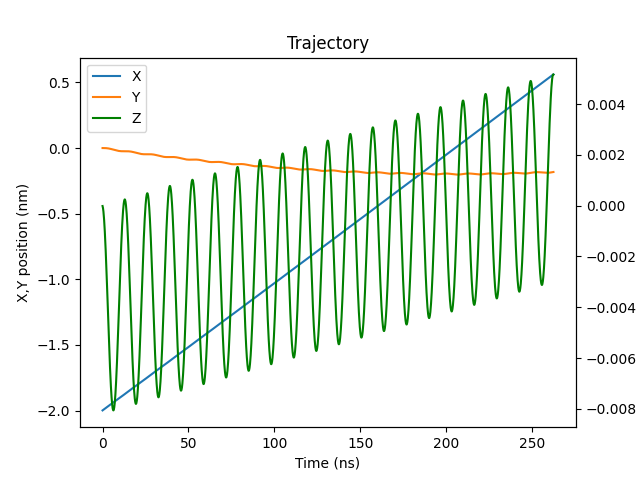

In [24]:
fig, ax = plt.subplots()
ax.set_title("Trajectory")
ax.set_xlabel("Time (ns)")

ax.plot(times.to(u.ns).value, x[:-1, 0].to(u.nm).value, label='X')
ax.plot(times.to(u.ns).value, x[:-1, 1].to(u.nm).value, label='Y')
ax.plot([], [], color='green', label='Z')
ax.set_ylabel("X,Y position (nm)")

ax2 = ax.twinx()
ax2.plot(times.to(u.ns).value, x[:-1, 2].to(u.nm).value, label='Z', color='green')
ax2.set_ylabel("Z position (nm)");
ax.legend();

<IPython.core.display.Javascript object>


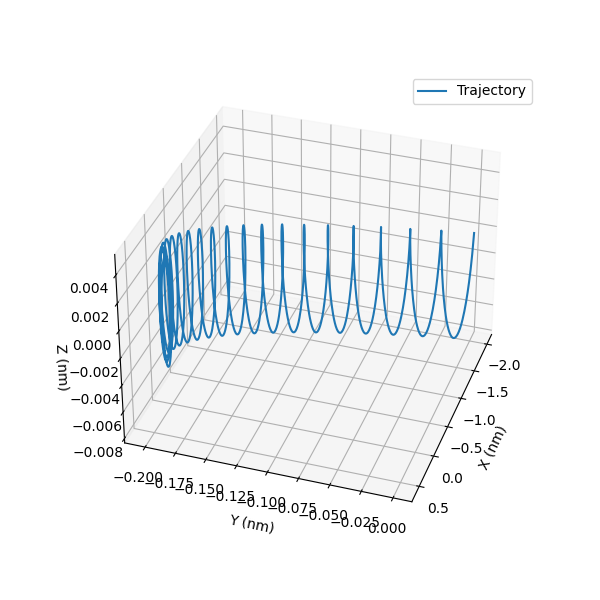

In [25]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

# Plot the orbit
ax.plot(x[:,0].to(u.nm).value, x[:,1].to(u.nm).value, x[:,2].to(u.nm).value, label="Trajectory")

# Plot the theoretical drift
x_final = (times[-1]*(v_ExB + np.array([0,0,v0[2].value])*v0.unit)).to(u.nm).value
#ax.plot(np.zeros(10), np.zeros(10), np.arange(10))
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_zlabel("Z (nm)")

ax.legend();